In [ ]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from  tensorflow.keras import layers
from  tensorflow.keras.applications import DenseNet121,NASNetLarge
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, applications
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization

# Set seeds to make the experiment more reproducible.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')

In [ ]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


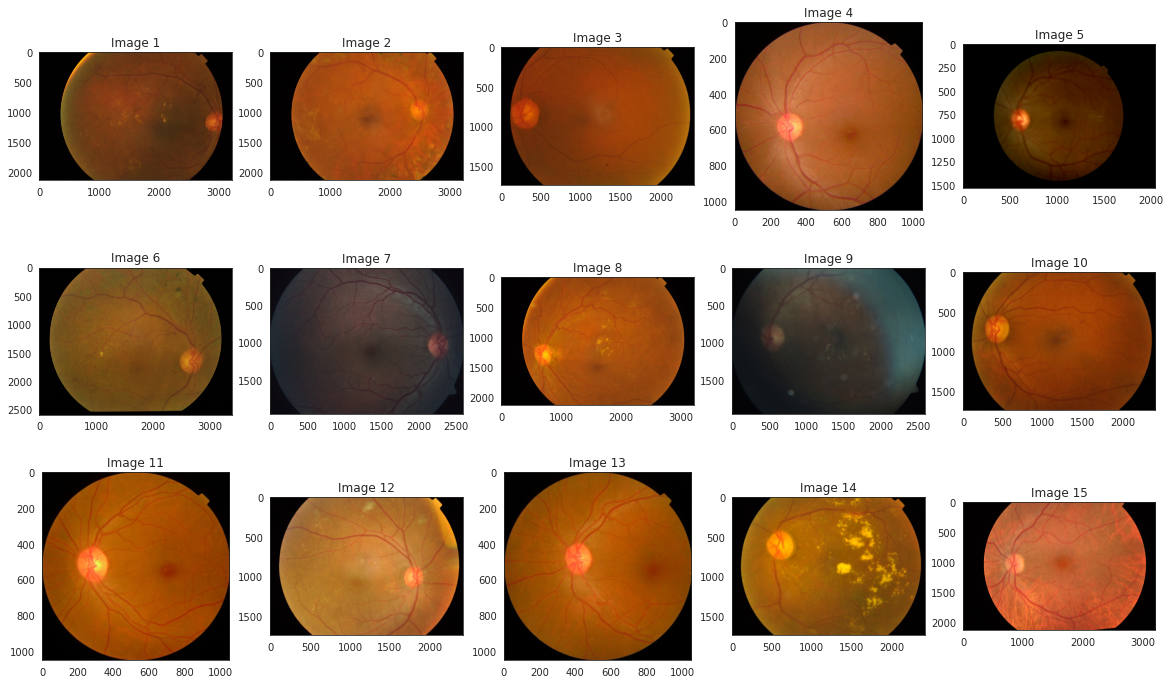

In [ ]:
sns.set_style("white")
count = 1
plt.figure(figsize=[20, 20])
for img_name in train['id_code'][:15]:
    img = cv2.imread("/content/drive/MyDrive/train_images/%s.png" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
plt.show()

In [ ]:
# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [ ]:
# Model parameters
BATCH_SIZE = 32 #32 #8
EPOCHS = 20
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 512
WIDTH = 512
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/drive/MyDrive/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/drive/MyDrive/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "/content/drive/MyDrive/test_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.initializers import Initializer
from tensorflow.keras.utils import get_custom_objects

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope, plot_model
from tensorflow.keras.initializers import glorot_uniform

In [ ]:
keras_model = tf.keras.models.load_model('/content/drive/MyDrive/model.h5', compile=False)
keras_model2 = tf.keras.models.load_model('/content/drive/MyDrive/model3.h5', compile=False)

In [ ]:
models = [keras_model, keras_model2]
model_input = tf.keras.Input(shape=( 224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
  ensemble_model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 5)            7042629     ['input_1[0][0]']                
                                                                                                  
 sequential (Sequential)        (None, 5)            4275001     ['input_1[0][0]']                
                                                                                                  
 average (Average)              (None, 5)            0           ['sequential_1[0][0]',       

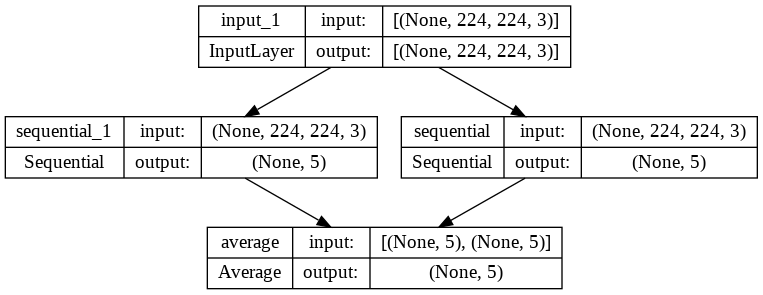

In [ ]:
plot_model(ensemble_model, 'model1.png', show_shapes=True)

In [ ]:
ensemble_model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=5,
                    validation_data=valid_generator,
                    validation_steps = test_generator.samples // BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/5
60/60 [==============================] - 145s 2s/step - loss: 0.6578 - accuracy: 0.8109 - val_loss: 0.4865 - val_accuracy: 0.8438
Epoch 2/5
60/60 [==============================] - 142s 2s/step - loss: 0.3962 - accuracy: 0.8655 - val_loss: 0.3896 - val_accuracy: 0.8562
Epoch 3/5
60/60 [==============================] - 140s 2s/step - loss: 0.3691 - accuracy: 0.8445 - val_loss: 0.3764 - val_accuracy: 0.8708
Epoch 4/5
60/60 [==============================] - 137s 2s/step - loss: 0.2611 - accuracy: 0.9160 - val_loss: 0.2559 - val_accuracy: 0.9104
Epoch 5/5
60/60 [==============================] - 138s 2s/step - loss: 0.2171 - accuracy: 0.9265 - val_loss: 0.2333 - val_accuracy: 0.9187


In [ ]:
ensemble_model.save('ense.h5')

Text(0, 0.5, '% Accuracy')

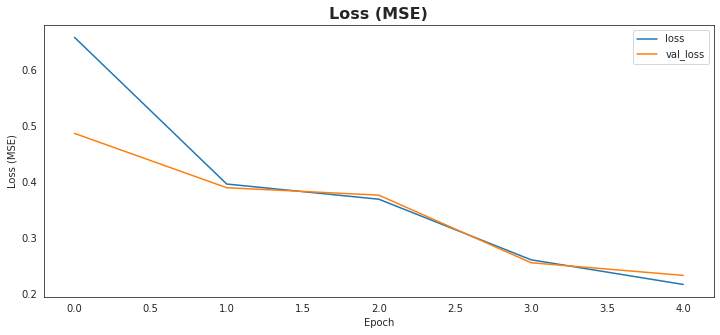

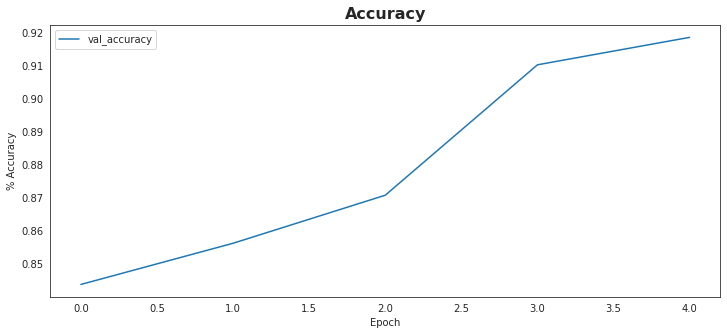

In [ ]:
history_df = pd.DataFrame(ensemble_model.history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy")

In [ ]:
history_df['val_accuracy'][4]

0.918749988079071

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
clf = tf.keras.models.load_model('/content/drive/MyDrive/model3.h5', compile=False)

In [ ]:
y_pred = clf.predict(test_generator,batch_size=4)

1928/1928 [==============================] - 109s 56ms/step


In [ ]:
print(len(y_pred))

1928


In [ ]:
y_test = train['diagnosis'].head(1928)

In [ ]:
y_pred

array([[0.05552792, 0.24495971, 0.11644471, 0.33021235, 0.25285527],
       [0.06567011, 0.20193194, 0.19504422, 0.37098724, 0.16636652],
       [0.05466763, 0.19810015, 0.0923247 , 0.43772927, 0.21717823],
       ...,
       [0.06071869, 0.18340418, 0.06648485, 0.35503587, 0.3343564 ],
       [0.09317251, 0.24968015, 0.13355863, 0.1895493 , 0.33403942],
       [0.13875777, 0.19717623, 0.20074607, 0.19905077, 0.26426914]],
      dtype=float32)

In [ ]:
y = np.argmax(y_pred, axis=1)

In [ ]:
y

array([3, 3, 3, ..., 3, 4, 4])

In [ ]:
act_d = y_test.to_numpy()
act_d = act_d.astype(np.int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
cm = confusion_matrix(act_d, y)

In [ ]:
"""
0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR
"""

'\n0 - No DR\n\n1 - Mild\n\n2 - Moderate\n\n3 - Severe\n\n4 - Proliferative DR\n'

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['No DR','Mild','Moderate','Severe','Proliferative DR'], 
                     columns = ['No DR','Mild','Moderate','Severe','Proliferative DR'])

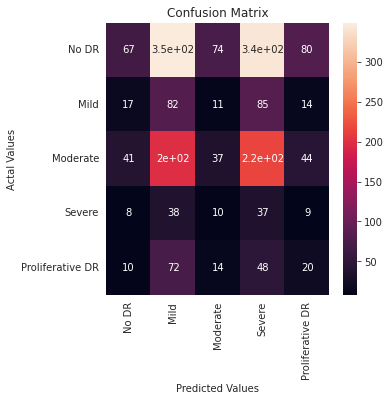

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
from sklearn.metrics import cohen_kappa_score
val = cohen_kappa_score(act_d, y, labels=None, weights=None)
print(val)

0.9379088604121397
